In [34]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from src.data.transforms import Rescale
from src.models.joint_face_det_model import JointDetectionModule
from src.data.Dataset import LS3DDataset
from src.models.loss import JointLoss
from src.models.metrics import map_eval, get_bbox
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data.dataloader import DataLoader
import albumentations as albu
import albumentations.pytorch.transforms
import torch
import cv2
from tqdm import tqdm
from loguru import logger

In [75]:
CHECKPOINT_PATH = '../models/joint_det_models/model_exc_fix.pth.tar'

In [76]:
from PIL import Image
from matplotlib import pyplot as plt, patches
import numpy as np
%matplotlib inline

def draw_image_with_landmarks_bbox(image, landmarks, bbox):
    fig, ax = plt.subplots(1)
    image = np.reshape(image, (288,288,3) )
    ax.scatter(landmarks[:, 0], landmarks[:, 1])
    rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    plt.show()
    
def draw_image_with_landmarks(image, landmarks):
    image = image[0].permute(1,2,0)
    landmarks = landmarks.view(68, 2)
    landmarks = landmarks.cpu().detach().numpy()
    fig, ax = plt.subplots(1)
    ax.imshow(image)
    ax.scatter(landmarks[:, 0], landmarks[:, 1])
    plt.show()

def draw_image_for_predicted_with_landmarks(image, landmarks):
    image = image[0].permute(1,2,0)
    fig, ax = plt.subplots(1)
    landmarks = landmarks.cpu().detach().numpy()
    landmarks = landmarks - 1
    landmarks = landmarks * 288
    landmarks = np.ma.masked_equal(landmarks,0)
    plt.imshow(image)
    ax.scatter(landmarks[:, 0], landmarks[:, 1])
    plt.show()

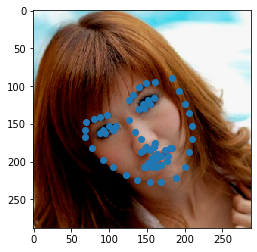

C:\w\1\s\tmp_conda_3.6_081743\conda\conda-bld\pytorch_1572941935551\work\aten\src\ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
C:\w\1\s\tmp_conda_3.6_081743\conda\conda-bld\pytorch_1572941935551\work\aten\src\ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
C:\w\1\s\tmp_conda_3.6_081743\conda\conda-bld\pytorch_1572941935551\work\aten\src\ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
C:\w\1\s\tmp_conda_3.6_081743\conda\conda-bld\pytorch_1572941935551\work\aten\src\ATen/native/IndexingUtils.h:20: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead.
C:\w\1\s\tmp_conda_3.6_081743\conda\conda-bld\pytorch_1572941935551\work\aten\src\ATen/native/IndexingUtils.h:20: UserWarning: index

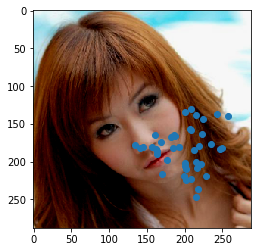

In [77]:
dataset = LS3DDataset(csv_file='../data/test.csv',
                          root_dir='../data/LS3D-W',
                          transformations=[Rescale(288)],
                          albu_transformations=[albu.PadIfNeeded(288, 288), albu.RandomBrightnessContrast(p=0.5),
                                                albu.HorizontalFlip(),
                                                albu.pytorch.transforms.ToTensor()])

dataloader = DataLoader(dataset, batch_size=1,
                            shuffle=True, num_workers=0)

model = JointDetectionModule()
checkpoint = torch.load(CHECKPOINT_PATH, map_location='cuda:0')
model.load_state_dict(checkpoint['model_state_dict'])
device = torch.device("cpu")
criterion = JointLoss(device)
#model.train()
for i, data in enumerate(dataloader):
    draw_image_with_landmarks(data['image'], data['landmarks_2d'])
    pred = model(data['image'])
    bbox_target=data['bbox']
    landmarks_target = data['landmarks_2d']

    nme, loc_loss, conf_loss, box_pred = criterion(pred, (bbox_target, landmarks_target))   
    box_pred, landmarks_pred = box_pred[0],box_pred[1].view(-1, 68,2)
    i = torch.argmax(box_pred[:,4])
    draw_image_for_predicted_with_landmarks(data['image'], landmarks_pred[i])
    break
    